In [1]:
from models import get_student_nn_classifier, get_vanilla_nn_classifier
from data_utils import prepare_data, load_dataset
from xgboost_utils import fit_xgboost_classifier, calculate_shap_values, \
    save_xgboost_classifier, load_xgboost_classifier
import numpy as np
from sklearn.metrics import classification_report, log_loss
import os
import os.path as osp
from tensorflow import keras
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
load_saved_values = False
save_values = False
use_weighted_shap_loss = False
xgb_max_depth, xgb_n_estimators = 10, 30
NUM_EPOCHS = 15

num_shap_features = 10
model_type = "student"  # "student", "vanilla"
dataset_name = 'costa_rica'  # 'otto' 'costa_rica' 'safe_drive', 'two_sigma_connect'
num_samples_to_keep = None  # None  1000
class_balancing_strategy = None  # "over_sample", "under_sample", None
normalize_features = False

X, y = load_dataset(dataset_name)
n_samples, n_features, n_classes, \
X_train, X_valid, y_train, y_valid, \
y_train_onehot, y_valid_onehot, y_onehot, \
class_weights = prepare_data(X, y, num_samples_to_keep,
                             class_balancing_strategy,
                             normalize_features)

loading costa_rica dataset


In [3]:
model_path = r"C:\Users\user\dev\copycat_master\experiments\costa_rica\student_nn.h5"
model = keras.models.load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
scores, shaps = model.predict(X_valid.values)
preds = np.argmax(scores, axis=1)
print("Student NN classification report:")
print(classification_report(y_valid.values, preds))
print("log_loss:", log_loss(y_valid.values, scores))

Student NN classification report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       151
           1       0.77      0.78      0.78       319
           2       0.72      0.72      0.72       242
           3       0.73      0.80      0.76       320

   micro avg       0.75      0.75      0.75      1032
   macro avg       0.77      0.74      0.75      1032
weighted avg       0.76      0.75      0.75      1032

log_loss: 0.7595990889864576


In [5]:
scores_train, shaps_train = model.predict(X_train.values)
preds_train = np.argmax(scores_train, axis=1)
print("Student NN TRAIN classification report:")
print(classification_report(y_train.values, preds_train))
print("log_loss:", log_loss(y_train.values, scores_train))

Student NN TRAIN classification report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       604
           1       0.97      0.94      0.96      1278
           2       0.96      0.93      0.95       967
           3       0.90      0.98      0.94      1277

   micro avg       0.95      0.95      0.95      4126
   macro avg       0.96      0.95      0.95      4126
weighted avg       0.95      0.95      0.95      4126

log_loss: 0.20504826786443425


In [6]:
imp_features = [
    'overcrowding', 'r4t2', 'hogar_adul', 'r4t3', 'epared3',
    'cielorazo', 'rooms', 'v18q', 'eviv3', 'paredblolad']
imp = [
    2295.7893, 1703.5262, 1663.403, 1424.5664, 1378.2969,
    1290.3743, 1214.7333, 1003.197, 965.49854, 839.18994]
# im_features_valid = [
#     'overcrowding', 'hogar_adul', 'r4t2', 'r4t3', 'epared3',
#     'cielorazo', 'rooms', 'v18q', 'eviv3', 'paredblolad']
# imp_valid = [
#     573.31165, 411.83887, 381.72842, 347.58365, 343.13425,
#     319.47754, 299.23328, 237.82652, 236.49037, 210.28201]

In [7]:
# i_feat = 1
# feat = imp_features[i_feat]
# max_add = X[feat].max() * 10
# change_vals = np.linspace(1e-5,max_add,101)

# ratios = []
# for to_change in tqdm(change_vals):
#     X_valid_play = X_valid.copy(deep=True)
#     X_valid_play[feat] = X_valid_play[feat] + to_change
#     scores_play, shaps_play = model.predict(X_valid_play.values)
#     shaps_diff = np.abs(shaps_play - shaps).sum(axis=(0,1))
#     shaps_diff_ratio = shaps_diff / max(shaps_diff.sum(), 1e-5)
#     _ratio = shaps_diff_ratio[i_feat]
#     ratios.append(_ratio)
    
# plt.plot(change_vals, ratios)

In [20]:
ratios = []
for i_feat in range(4):
    feat = imp_features[i_feat]
#     max_add = X[feat].max() * 10
    change_vals = np.linspace(1e-5,30,30)

    _ratios = []
    for to_change in tqdm(change_vals):
        X_valid_play = X_valid.copy(deep=True)
        X_valid_play[feat] = X_valid_play[feat] + to_change
        scores_play, shaps_play = model.predict(X_valid_play.values)
        shaps_diff = np.abs(shaps_play - shaps).sum(axis=(0,1))
        shaps_diff_ratio = shaps_diff / max(shaps_diff.sum(), 1e-5)
        _ratio = shaps_diff_ratio[i_feat]
        _ratios.append(_ratio)

    ratios.append(_ratios)

Text(0.5, 1.0, 'Compatibility between pred SHAPs and actual features')

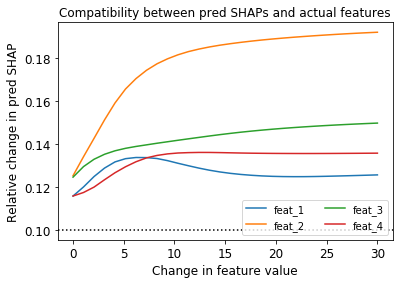

In [25]:
# plt.figure(figsize=(8, 6))
for i_feat in range(4):
    plt.plot(change_vals, ratios[i_feat], label="feat_%d" % (i_feat + 1))
plt.rcParams["font.size"] = 10.
plt.axhline(0.1, color='k', linestyle=':')
plt.legend(loc="lower right", ncol=2)
plt.xlabel("Change in feature value")
plt.ylabel("Relative change in pred SHAP")
plt.title("Compatibility between pred SHAPs and actual features")

In [13]:
raise

RuntimeError: No active exception to reraise

[<matplotlib.lines.Line2D at 0x14868358>]

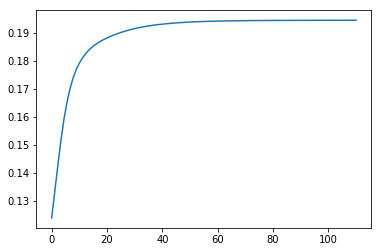

In [10]:
i_feat = 1
feat = imp_features[i_feat]
max_add = X[feat].max() * 10
change_vals = np.linspace(1e-5,max_add,101)

ratios_train = []
for to_change in tqdm(change_vals):
    feat = imp_features[i_feat]
    X_train_play = X_train.copy(deep=True)
    X_train_play[feat] = X_train_play[feat] + to_change
    scores_play, shaps_play = model.predict(X_train_play.values)
    shaps_diff = np.abs(shaps_play - shaps_train).sum(axis=(0,1))
    shaps_diff_ratio = shaps_diff / max(shaps_diff.sum(), 1e-5)
    _ratio = shaps_diff_ratio[i_feat]
    ratios_train.append(_ratio)
    
plt.plot(change_vals, ratios_train)

ValueError: x and y must have same first dimension, but have shapes (101,) and (4, 30)

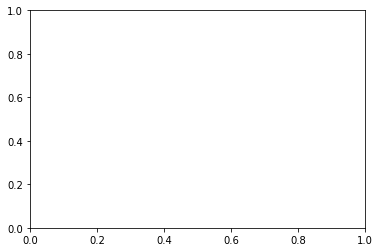

In [11]:
plt.plot(change_vals, ratios)
plt.plot(change_vals, ratios_train)